## Description

Microsoft sells a software application for $39. 

Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. 

In the experiment, 66% of the users have seen the old price (USD 39), while a random sample of 33% users a higher price (USD 59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially, you were asked the following questions:

1. Should the company sell its software for USD 33 or USD 59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

## Data

The two tables are:

#### test_results - data about the test

Columns:

* user_id : the Id of the user. Can be joined to user_id in user_table
* timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time
* source : marketing channel that led to the user coming to the site. It can be:
ads-[“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google ads, yahoo ads, etc.
* seo - [“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google search, yahoo, facebook, etc.
* friend_referral : user coming from a referral link of another user
* direct_traffic: user coming by directly typing the address of the site on the browser
* device : user device. Can be mobile or web.
* operative_system : user operative system. Can be: “windows”, “linux”, “mac” for web, and “android”, “iOS” for mobile. "Other" if it is none of the above
* test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower price)
* price : the price the user sees. It should match test
* converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

#### user_table - Information about the user

Columns:

* user_id : the Id of the user. Can be joined to user_id in test_results table
* city : the city where the user is located. Comes from the user ip address
* country : in which country the city is located
* lat : city latitude - should match user city
* long : city longitude - should match user city


## Imports & read dataset

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
from matplotlib import rcParams

rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

In [45]:
test = pd.read_csv("https://drive.google.com/uc?export=download&id=1BXA2DsA6Ii0ah9HZrjR0hjiEm4RNXtd1")
print(test.head())

   user_id            timestamp          source  device operative_system  test  price  converted
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS     0     39          0
1   624057  2015-05-10 21:08:46      seo-google  mobile          android     0     39          0
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android     0     39          0
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS     1     59          0
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac     0     39          0


In [46]:
user = pd.read_csv("https://drive.google.com/uc?export=download&id=1BXY31hD4o5anmBYu0v-YVeT_gOu63ocD")
print(user.head())

   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68


#### Check for missing values

In [47]:
print(test.isnull().sum())

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64


In [48]:
print(user.isnull().sum())

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


#### Merge tables

In [49]:
data=pd.merge(left=test, right=user, how='left', on='user_id')

print(data.head())

   user_id            timestamp          source  device operative_system  ...  converted          city  country    lat   long
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS  ...          0       Buffalo      USA  42.89 -78.86
1   624057  2015-05-10 21:08:46      seo-google  mobile          android  ...          0     Lakeville      USA  44.68 -93.24
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android  ...          0         Parma      USA  41.38 -81.73
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS  ...          0  Fayetteville      USA  35.07 -78.90
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac  ...          0       Fishers      USA  39.95 -86.02

[5 rows x 12 columns]


#### Check missing values

Since there were no missing values before the join, this would mean some users are in the test table, but not in the user table.

In [50]:
print(data.isnull().sum())

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64


Let's check if, in fact, those missing values are exactly the number of rows in the test table - user table.

In [51]:
print(max(data.isnull().sum())==(test.shape[0]-user.shape[0]))

True


Whenever two columns are supposed to always agree/be consistent (like test and price here), one of the first things to do is to check if they always agree. 

So, let’s check if people in test always get the USD 59 price and people in control USD 39 price.

In [52]:
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918


There are some issues. A small number of users appear to be getting the wrong price based on their test/control assignment.

As the number here is pretty small, we can just remove them and move on with our analysis. However, this should be investigated further in case there is some bigger bug that might be impacting something else.

In [53]:
data=data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
1    59      113918


Let's now create the revenue variable.

In [54]:
data['revenue']=data['converted']*data['price']

print(data['revenue'].describe())

count    316435.000000
mean          0.827083
std           6.179009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: revenue, dtype: float64


## Q: Should the company sell its software for 39 or 59?

First let's compare conversion rate. We expect the conversion rate to drop, let's check by how much.

In [55]:
print(data[['converted','test']].groupby('test').mean())

      converted
test           
0      0.019900
1      0.015555


Check average revenue per user

In [56]:
print(data[['revenue','test']].groupby('test').mean())

       revenue
test          
0     0.776083
1     0.917748


It looks like revenue per user is up. Let’s now check if this is statistically significant.

In [57]:
print(ttest_ind(data[data['test']==1]['revenue'], data[data['test']==0]['revenue'], equal_var=False))

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)


It looks like revenue per user is up and highly statistically significant.

Let’s now check how different segments are reacting to the test. This can give us extremely useful information about user price sensitivity by segment, which is really just a fancy way to say: how much different users are valuing our product?

#### By source

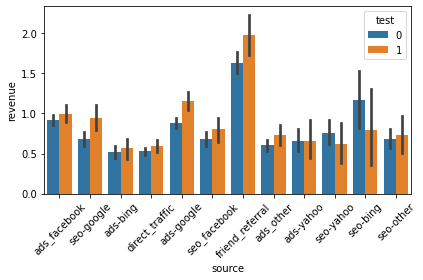

In [58]:
sns.barplot(x='source', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

Most segments agree with the overall finding of an increase in revenue as we increase price. Unfortunately, the three segments with the higher avg revenue with the new price happen to be the most expensive ones, i.e. friend referral, and Google/FB ads.

Let’s now check device:

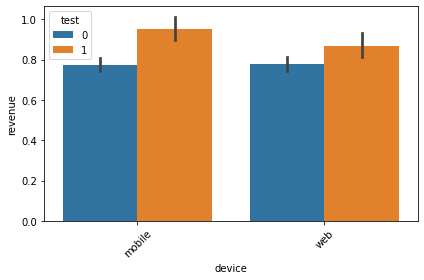

In [59]:
sns.barplot(x='device', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

It appears that mobile users are less price sensitive. This is typically very good as mobile is in most cases the channel that’s proportionally growing more between the two. So, in the long run, the revenue gain from the price change could be even larger.

Let’s now check OS:

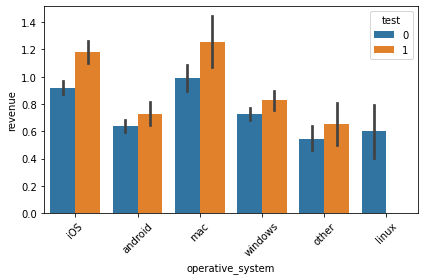

In [60]:
sns.barplot(x='operative_system', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

Not surprisingly, we can see that mac/iOS react better to the price increase. Most likely, they are acting as a proxy for different user characteristics. It would probably be a good idea to figure out how to get more of those users and target them more via, for instance, ads or ad-hoc marketing campaigns.

Most importantly though, Linux has 0% conversion rate for test. 

That’s almost impossible and most likely a bug. Having a bug on a given segment might be biasing the results. Let’s remove that segment from the dataset and redo the statistical test.

#### Number of Linux users

In [61]:
print(data.query('operative_system==\'linux\'').shape[0]/data.shape[0])

0.01305165357814401


It is only 1%. But still, let’s redo the test after removing those users:

#### Average revenue per user after removing Linux

In [62]:
data = data.query('operative_system!=\'linux\'')
print(data[['revenue','test']].groupby('test').mean())

       revenue
test          
0     0.778002
1     0.933531


In [63]:
print(ttest_ind(data.query('test==1')['revenue'], data.query('test==0')['revenue'], equal_var=False))

Ttest_indResult(statistic=6.184240028400434, pvalue=6.253458285742887e-10)


Since the bug was in test, as expected the overall numbers improve slightly. We could quickly recheck the plots of OS and source with the new dataset after removing linux, however it is highly unlikely insights will be different, given the small proportion of linux users.

#### By city

Let’s now check city. We will just check the top 10 cities in terms of user base:

In [64]:
top_cities=data['city'].value_counts().reset_index().sort_values('city', ascending=False).head(10)
print(top_cities)

          index   city
0      New York  25401
1       Chicago   7071
2       Houston   6608
3   San Antonio   4554
4   Los Angeles   4089
5      San Jose   3312
6  Indianapolis   3177
7  Jacksonville   2865
8  Philadelphia   2488
9     Las Vegas   2375


#### Plot average revenue for top 10 cities

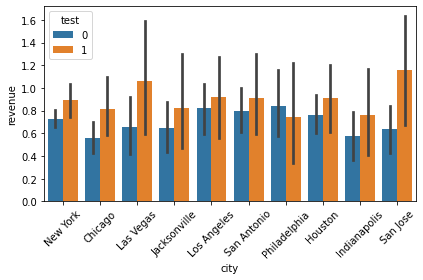

In [65]:
sns.barplot(x='city', y='revenue', hue='test', data=data[data['city'].isin(top_cities['index'])])
plt.xticks(rotation=45)
plt.show()

Results appear pretty different by city, but it is hard to draw any conclusions. The city variable has so many levels that, by chance only, we are expected to find a lot of different results. However, combining this with domain/product knowledge could lead to create some hypotheses that could be then A/B tested in a more statistically sound way.

## Conclusions

Overall, it appears clear that if the goal of the test was trying to increase revenue, then the test has won and we should go ahead with the change. However, there are a few more things to consider before going ahead with a price change, beside the short term revenue impact.

The negative side is that we are losing roughly 25% of customers. What will be the impact of this on certain growth channels? Especially, word-of-mouth related growth. Even more considering that friend-referral (which can be seen as a proxy for word of mouth) is doing so well.

The positive side is that larger revenue per user typically means that the company can bid higher for ads or, more generally, invest more money in most marketing channels. So, in the long run, this should give the opportunity of increasing the number of customers and, therefore, total revenue.

Other general insights are:

* Friend-referral is by far the best channel. Any UI/UX change that emphasizes it is even more is likely to lead to revenue gains

* After referrals, FB/Google ads have higher revenue per user than any other channel. This is kind of expected. However, SEO is not really that much behind. And SEO is free. Focusing on SEO and increasing its relative share of traffic would lead to much larger profits

* Mobile has larger revenue per user than web. This is an excellent news. Mobile share of traffic has been growing constantly over the last few years. Just by taking advantage of this trend, the company will make more money. If they could increase mobile traffic even more, they would make even more money. Bidding higher for mobile ads is probably a good idea

* iOS is doing much better than Android. Most likely, this is just because iOS users are less price sensitive than Android users. However, it would still be interesting investigating whether the actual product (i.e. UI/UX) is different between the two platforms

* Revenue per user varies greatly across segments. This could lead to potentially understanding why and coming up with different products, some cheaper and some more expensive.

## [Extra] After how many days would you have stopped the test?

To know for how long a test should be run, we first need to figure out what’s the minimum required sample sample per group.

In order to calculate that, we would need to know what’s the test detectable effect we are looking for. Given this is not a real-world scenario, here we can just show what the sample size would be under certain assumptions.

Let’s say significance level and power are the standard 0.05 and 0.8. Let’s also assume we are interested in detecting a difference in conversion rate of about ~33%, i.e. ~1-39/59. That is, if the new conversion rate is about 66% of the old one we are good.

In [66]:
conversion_rate_control = test.query('test==0').converted.mean()
p1_and_p2 = sms.proportion_effectsize(conversion_rate_control, conversion_rate_control*39/59)
sample_size = round(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
print("The required sample size per group is ~", sample_size)

The required sample size per group is ~ 5548


Let’s now check how many users we have per week to figure out how long it will take to get enough users:

In [67]:
# create column for week of the year
test['week_year'] = pd.to_datetime(test.timestamp.str.split(' ').str[0]).dt.strftime('%W')

# take average count of users per week. We remove first and last week, as they may not include all 7 days
users_week = test['week_year'].value_counts().sort_index()
users_week = users_week.drop(users_week.index[[0,(users_week.shape[0]-1)]]).mean()
  
print("Avg number of users per week is:", round(users_week))

Avg number of users per week is: 24356


If we ran the test on 50% of the users, we would be done in less than a week. However, it is a good practice to run the test for at least two weeks regardless of that, so that we can get weekly patterns. In terms of percentage split, we can look at what’s the minimum percentage of users that would need to be in test to get the required sample size in two weeks. That is:

In [68]:
print("The percentage of traffic that needs to be in test is", round(sample_size/(users_week*2)*100))

The percentage of traffic that needs to be in test is 11
